# Group Project

## Data:

The data is about University Rankings across the world in 2023. It consists of 2342 rows corresponding to 1799 universities across 104 countries and regions and 13 features. The features are determined based on 4 popular performance indicators of an institution: teaching, research, knowledge transfer and international outlook. The data is collected through 121 million citations of 15.5 million research publications and a survey conducted on 40,000 scholars worldwide. The features include:
1. `University Rank`: Rank of the university (chr)
2. `Name of University`: Name of the university (chr)
3. `Location`: Country or region the university is located (chr)
4. `No of student `: Number of students enrolled in the university currently (chr)
5. `No of student per staff`: Number of students per one professor (dbl)
6. `International Student`: Number of international students (chr)
7. `Female : Male Ratio`: Ratio of female : male (chr)
8. `OverAll Score`: University overall score out of 100 (chr)
9. `Teaching`: Rating of teaching score out of 100 (chr)
10. `Research Score`: Rating of research (chr) 
11. `Citations Score`: Number of citations received by a journal in one year divided by number of documents published in the three previous years (chr)
12. `Industry Income Score`: How much money a university receives from the industry in return for its academic expertise (chr)
13. `International Outlook Score`: The ability of a university to attract undergraduates, postgraduates and faculty comparing to other universities around the world (chr) <br>

It is also necessary to mention a cleaned version of this dataset. The updates include assigning missing values with "Unknown", one hot encoding for `Name of University` and `Location` columns, seperating  Female : Male Ratio into `Female Ratio` and `Male Ratio` columns, dividing `OverAll Score` into `OverAll Score Min` and `OverAll Score Max` columns, and converting all related columns(`Female Ratio`, `Male Ratio`, `OverAll Score Min`, `OverAll Score Max`, `No of Student`, and `International Student`) into numerical type. The clean dataset will be of use for data analysis and machine learning modelling especially predictive model.

## Data Cleaning/Wrangling:

The following are libraries that are essential for the model to be created.

In [50]:
install.packages("viridis")
install.packages("mice")
library(tidyverse)
library(broom)
library(cowplot)
library(reshape2)
library(viridis)
library(rsample)
library(glmnet)
library(mice)
theme_set(theme_bw())
options(repr.plot.width = 12, repr.plot.height =10)

Warning message:
"package 'viridis' is in use and will not be installed"
Warning message:
"package 'mice' is in use and will not be installed"


Next, I will use read.csv() to read the dataset, and head() to get a first view of the dataset.


In [51]:
df <- read.csv("https://raw.githubusercontent.com/RayNguyent/STAT301-project/main/data/World%20University%20Rankings%202023.csv")

In [52]:
head(df)

,University.Rank,Name.of.University,Location,No.of.student,No.of.student.per.staff,International.Student,Female.Male.Ratio,OverAll.Score,Teaching.Score,Research.Score,Citations.Score,Industry.Income.Score,International.Outlook.Score
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,University of Oxford,United Kingdom,"20,965",10.6,42%,48 : 52,96.4,92.3,99.7,99.0,74.9,96.2
2,2,Harvard University,United States,"21,887",9.6,25%,50 : 50,95.2,94.8,99.0,99.3,49.5,80.5
3,3,University of Cambridge,United Kingdom,"20,185",11.3,39%,47 : 53,94.8,90.9,99.5,97.0,54.2,95.8
4,3,Stanford University,United States,"16,164",7.1,24%,46 : 54,94.8,94.2,96.7,99.8,65.0,79.8
5,5,Massachusetts Institute of Technology,United States,"11,415",8.2,33%,40 : 60,94.2,90.7,93.6,99.8,90.9,89.3
6,6,California Institute of Technology,United States,"2,237",6.2,34%,37 : 63,94.1,90.9,97.0,97.3,89.8,83.6


Next, I renamed the columns of the dataset to a better format.

In [53]:
names(df) <- c('university_rank','university_name','location','Num_student','No_of_student_per_staff','International_student','Female.male.ratio','Overall_score','Teaching_score','Research_score','Citations_score','Industry_income_score','International_outlook_score')

I noticed `Num_student` column is formatted as `,` instead of `.`, so I used `gsub()` to replace `,` with`.` The same applied to `Internation_student` where I got rid of `%`, then divided the values by 100(next code cell).

In [54]:
df$Num_student<- gsub(',', '', df$Num_student)
df$International_student<- gsub('%', '', df$International_student)


In order to perform data analysis for further tasks, I changed the data type of numerical columns to `double` type.

In [55]:
df <- df %>% mutate_at(c ('university_rank','Num_student', 'International_student','No_of_student_per_staff','Overall_score','Teaching_score',
                          'Research_score','Industry_income_score','Citations_score','International_outlook_score'), as.double)
df <- df %>% mutate(International_student = International_student/100)

Warning message:
"There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `university_rank = .Primitive("as.double")(university_rank)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings."


In order to extract information about the ratio between males and females in each university, I separated the original column into the `Female_percentage` and `Male_percentage` columns. I deleted this column because the `Female.male.ratio` is redundant.

In [56]:
get_female_percentage <- function(ratio) {
  if (is.na(ratio)) {
    return("nan")
  } else if (is.numeric(ratio)) {
    return(ratio)
  } else {
    ratio_parts <- unlist(strsplit(ratio, " : "))
    x <- as.integer(ratio_parts[1])
    y <- as.integer(ratio_parts[2])
    
    fract <- round(x / (y + x), 2)
    return(fract)
  }
}

get_male_percentage <- function(ratio) {
  if (is.na(ratio)) {
    return("nan")
  } else if (is.numeric(ratio)) {
    return(ratio)
  } else {
    ratio_parts <- unlist(strsplit(ratio, " : "))
    x <- as.integer(ratio_parts[1])
    y <- as.integer(ratio_parts[2])
    
    fract <- round(y / (y + x), 2)
    return(fract)
  }
}
df$Female_Percentage <- sapply(df$Female.male.ratio, get_female_percentage)
df$Male_Percentage <- sapply(df$Female.male.ratio, get_male_percentage)
df <- df[, -which(names(df) == "Female.male.ratio")]

Since `Internation_outlook_score` is the target value, it is better to drop all the rows that have a null value in that column. It is also worth noticing that the `university_rank` column has a lot of null values. 

In [57]:
df <- df %>% drop_na(International_outlook_score)

In [58]:
data.frame(sapply(df, function(x) sum(is.na(x))))

,sapply.df..function.x..sum.is.na.x...
,<int>
university_rank,1600
university_name,0
location,0
Num_student,102
No_of_student_per_staff,102
International_student,103
Overall_score,1599
Teaching_score,0
Research_score,0


## EDA

This is a histogram that shows the distribution of the international outlook score(y), the target variable. It is important to understand the distribution of y(target) so that we understand the spread, tendency, and shape of the data. The international outlook score plot is unimodal and peaks at around 24 or 25. Besides, the plot is right-skewed with no significant outliers, which indicates a majority of schools have low to average outlook scores.

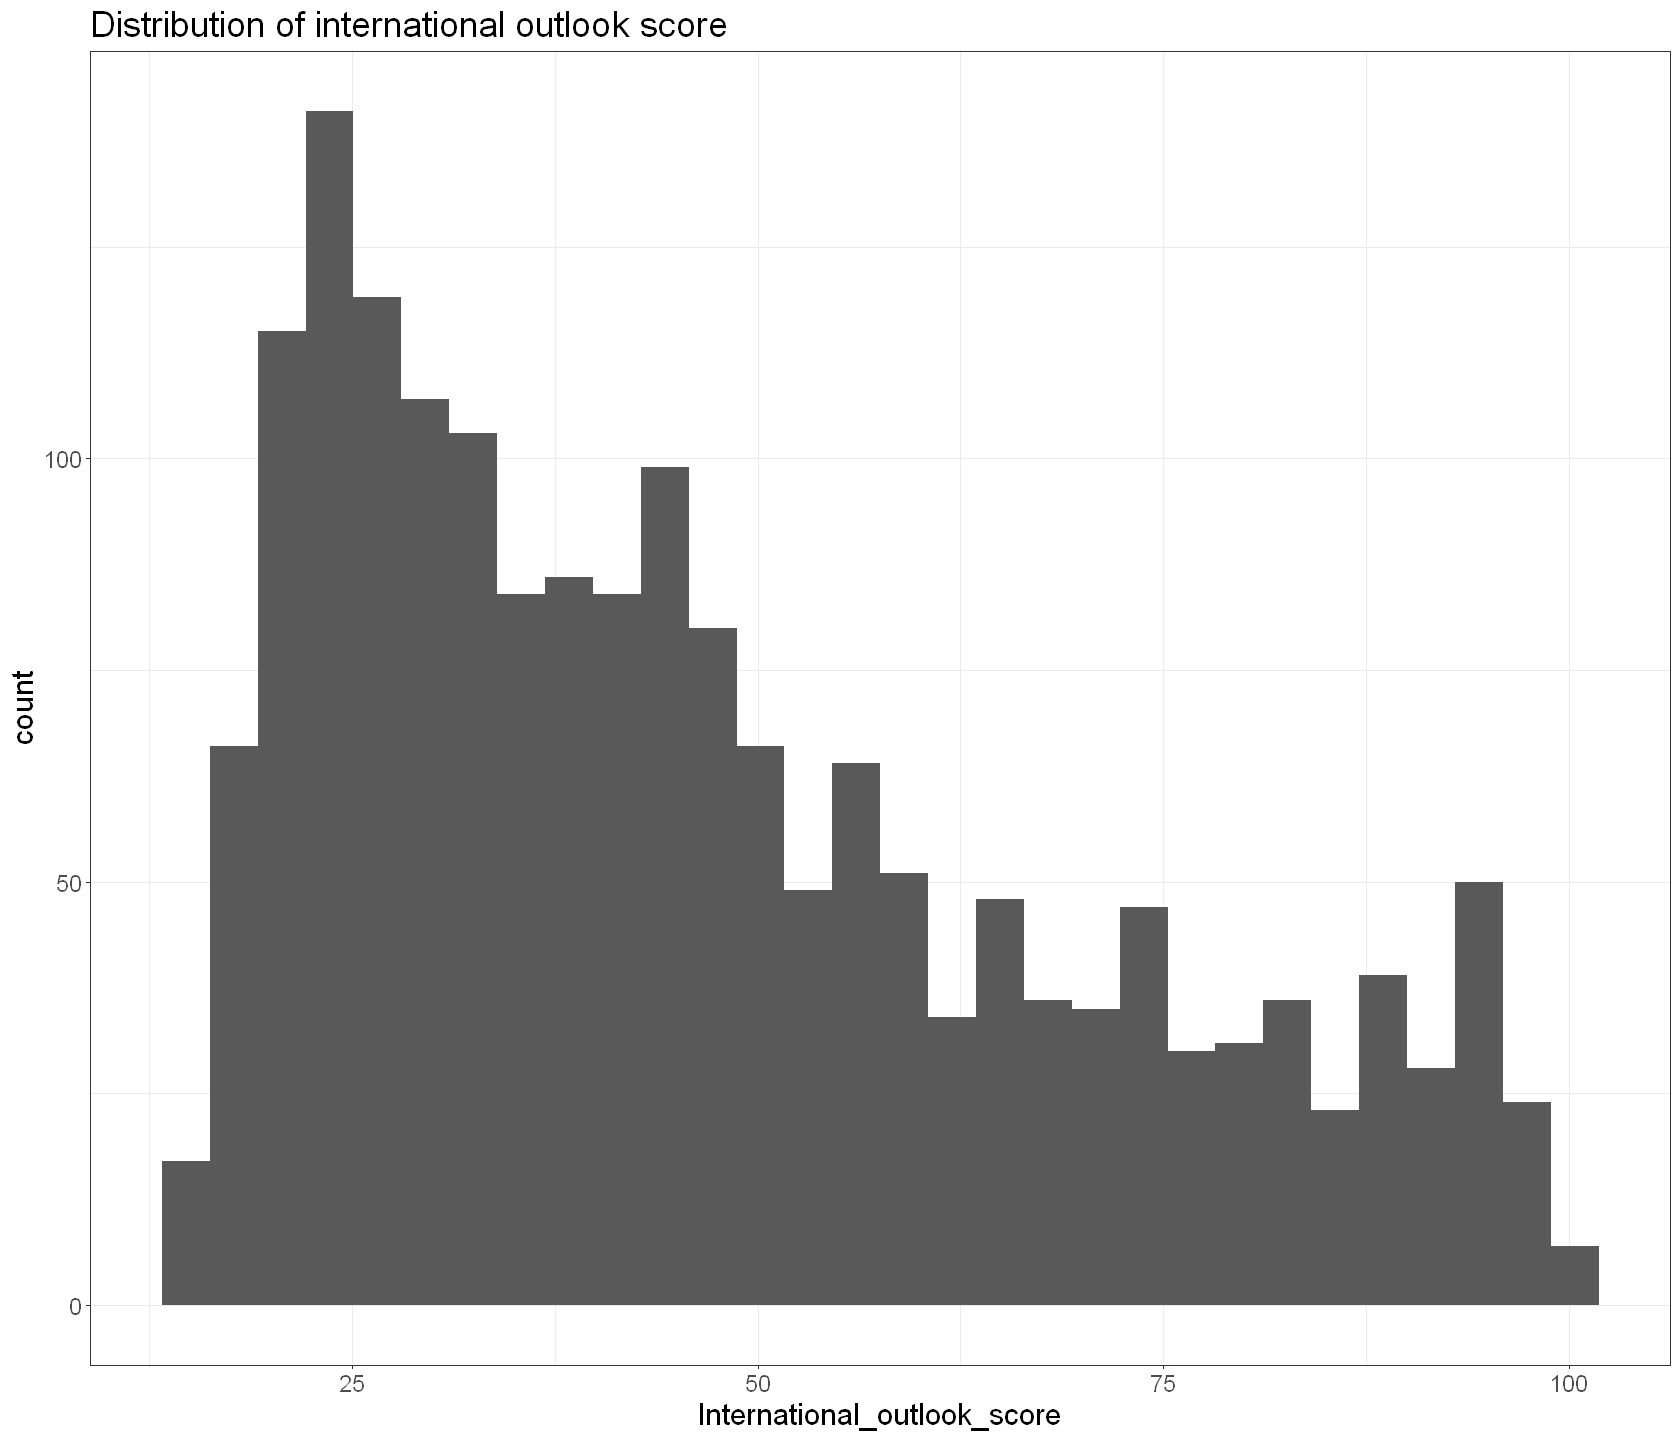

In [59]:
options(repr.plot.width = 14, repr.plot.height =12)
df %>% ggplot(aes(x=International_outlook_score)) + geom_histogram(bins=30) + labs(title = "Distribution of international outlook score") +
theme(text = element_text(size=18))
                                                                                        

By common sense, `Overall_score` is likely to be correlated with `Teaching_score`, `Citations_score`, `Industry_income_score`, and `Research_score`. According to plots, `Teaching_score`, `Citations_score`, and `Research_score` have relatively strong positive relationships with `Overall_score`, whereas `Industry_income_score` shows no significant relationship with `Overall_score`. This collinearity will largely affect the model training later, and as mentioned above, `Overall_score` has many null values. I decided to drop the `Overall_score` column.


Warning message:
"Removed 1599 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1599 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1599 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1599 rows containing missing values (`geom_point()`)."


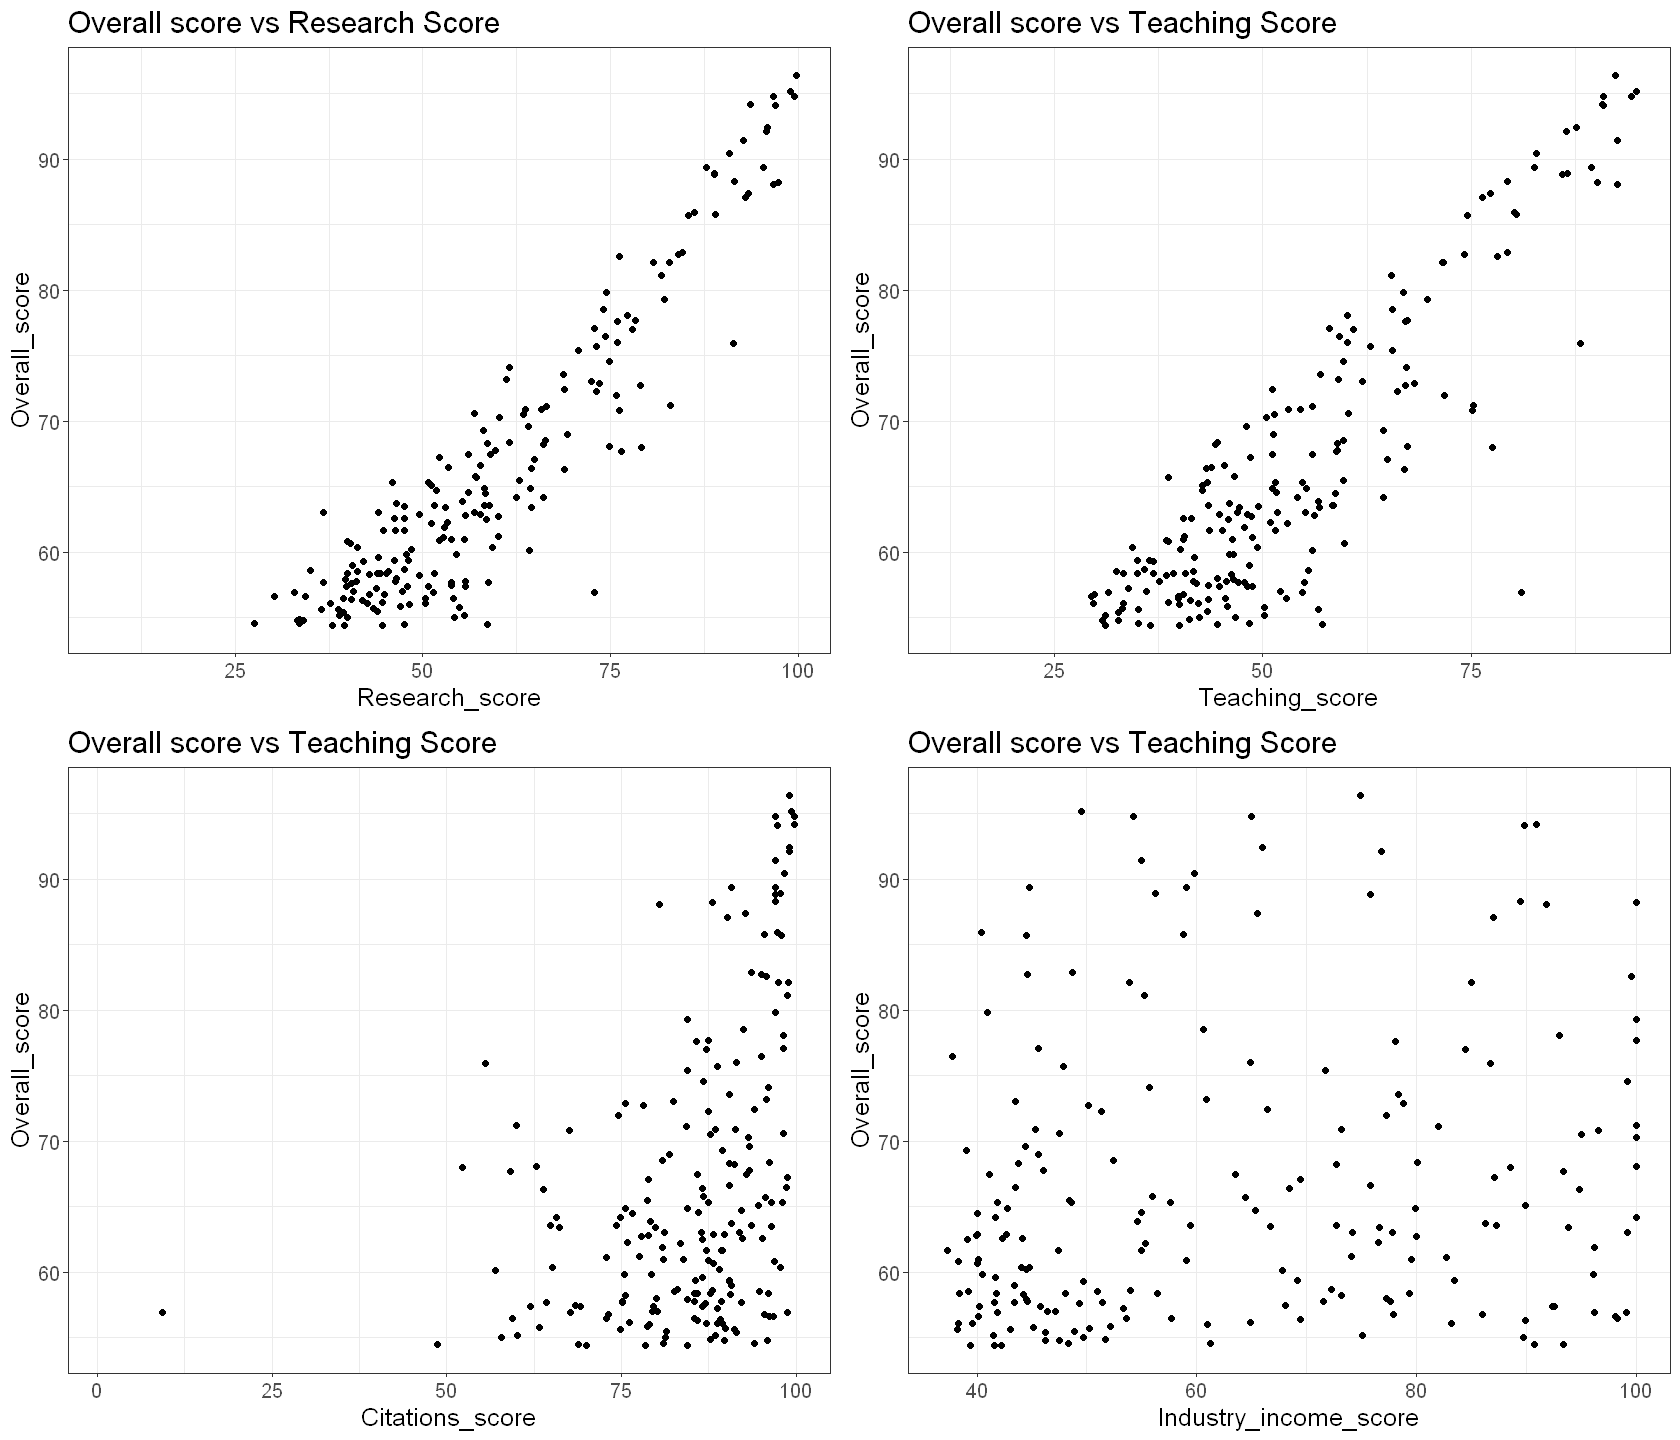

In [60]:
options(repr.plot.width = 14, repr.plot.height =12)
p1<-df %>% ggplot(aes(x=Research_score,y=Overall_score)) + geom_point() + labs(title = "Overall score vs Research Score")+theme(text = element_text(size=15))
p2<-df %>% ggplot(aes(x=Teaching_score,y=Overall_score)) + geom_point() + labs(title = "Overall score vs Teaching Score")+theme(text = element_text(size=15))
p3<-df %>% ggplot(aes(x=Citations_score,y=Overall_score)) + geom_point() + labs(title = "Overall score vs Teaching Score")+theme(text = element_text(size=15))
p4<-df %>% ggplot(aes(x=Industry_income_score,y=Overall_score)) + geom_point() + labs(title = "Overall score vs Teaching Score")+theme(text = element_text(size=15))
plot_grid(p1, p2, p3, p4)

There is evidence that universities with high international outlook scores also boast a significant percentage of international students. The plot illustrating `International_outlook_score` versus `International_student` underscores this connection. A strong positive relationship between these two variables is witnessed. Additionally, noteworthy high-leverage observations on the far right of the plot indicate the presence of universities with both a majority of international students and high international outlook scores.

`geom_smooth()` using method = 'gam'
Warning message:
"Removed 103 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 103 rows containing missing values (`geom_point()`)."


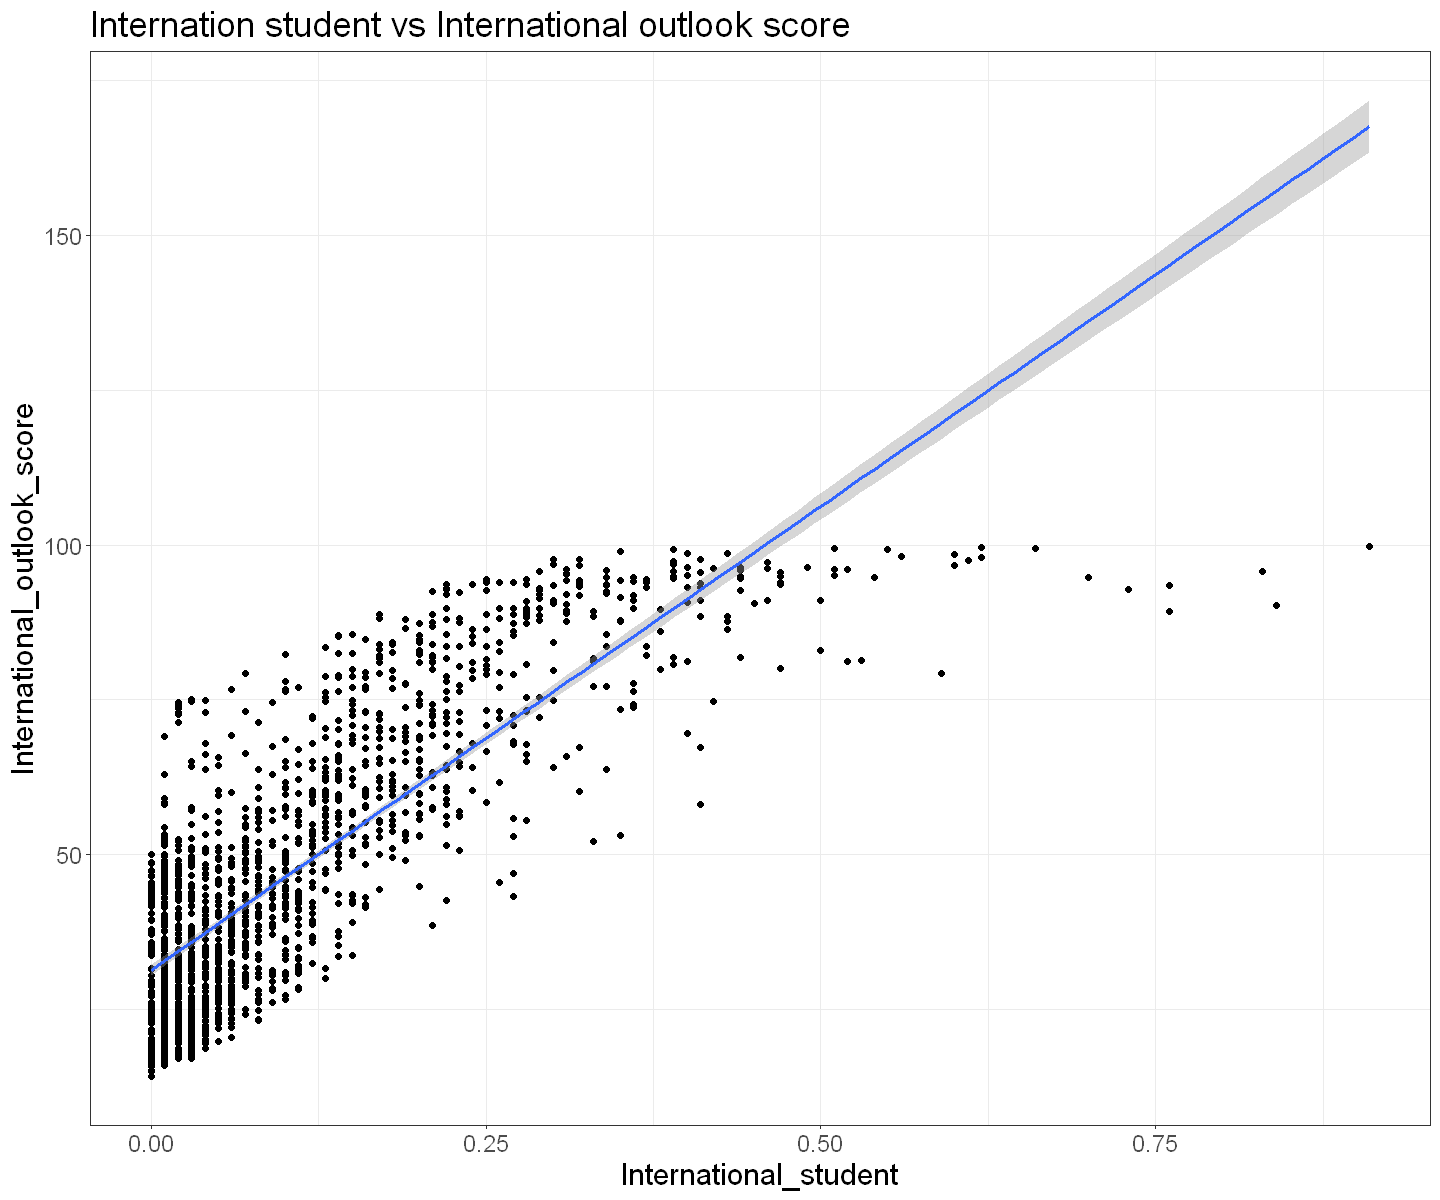

In [61]:
options(repr.plot.width = 12, repr.plot.height =10)
df %>% ggplot(aes(x=International_student,y=International_outlook_score)) + geom_point() + geom_smooth(formula=y~x) + theme(text = element_text(size=18)) + 
labs(title = "Internation student vs International outlook score")

This is a heatmap of correlations between all the scores including `International_outlook_score`(y), target value. A heatmap will indicate if the scores are linearly correlated with y, which helps decide whether we should keep the variables for the linear model. The plot demonstrates a fairly high positive correlation, 0.54, between `Citations_score`, `Research_score` and y. The least correlated explanatory variable is `Industry_income_score` with a value of 0.22. It is worth noting that `Research_score` and `Teaching_score` are highly correlated producing a correlated coefficient of 0.88. We will have to conduct further analysis into these two variables to avoid collinearity when training the model. 

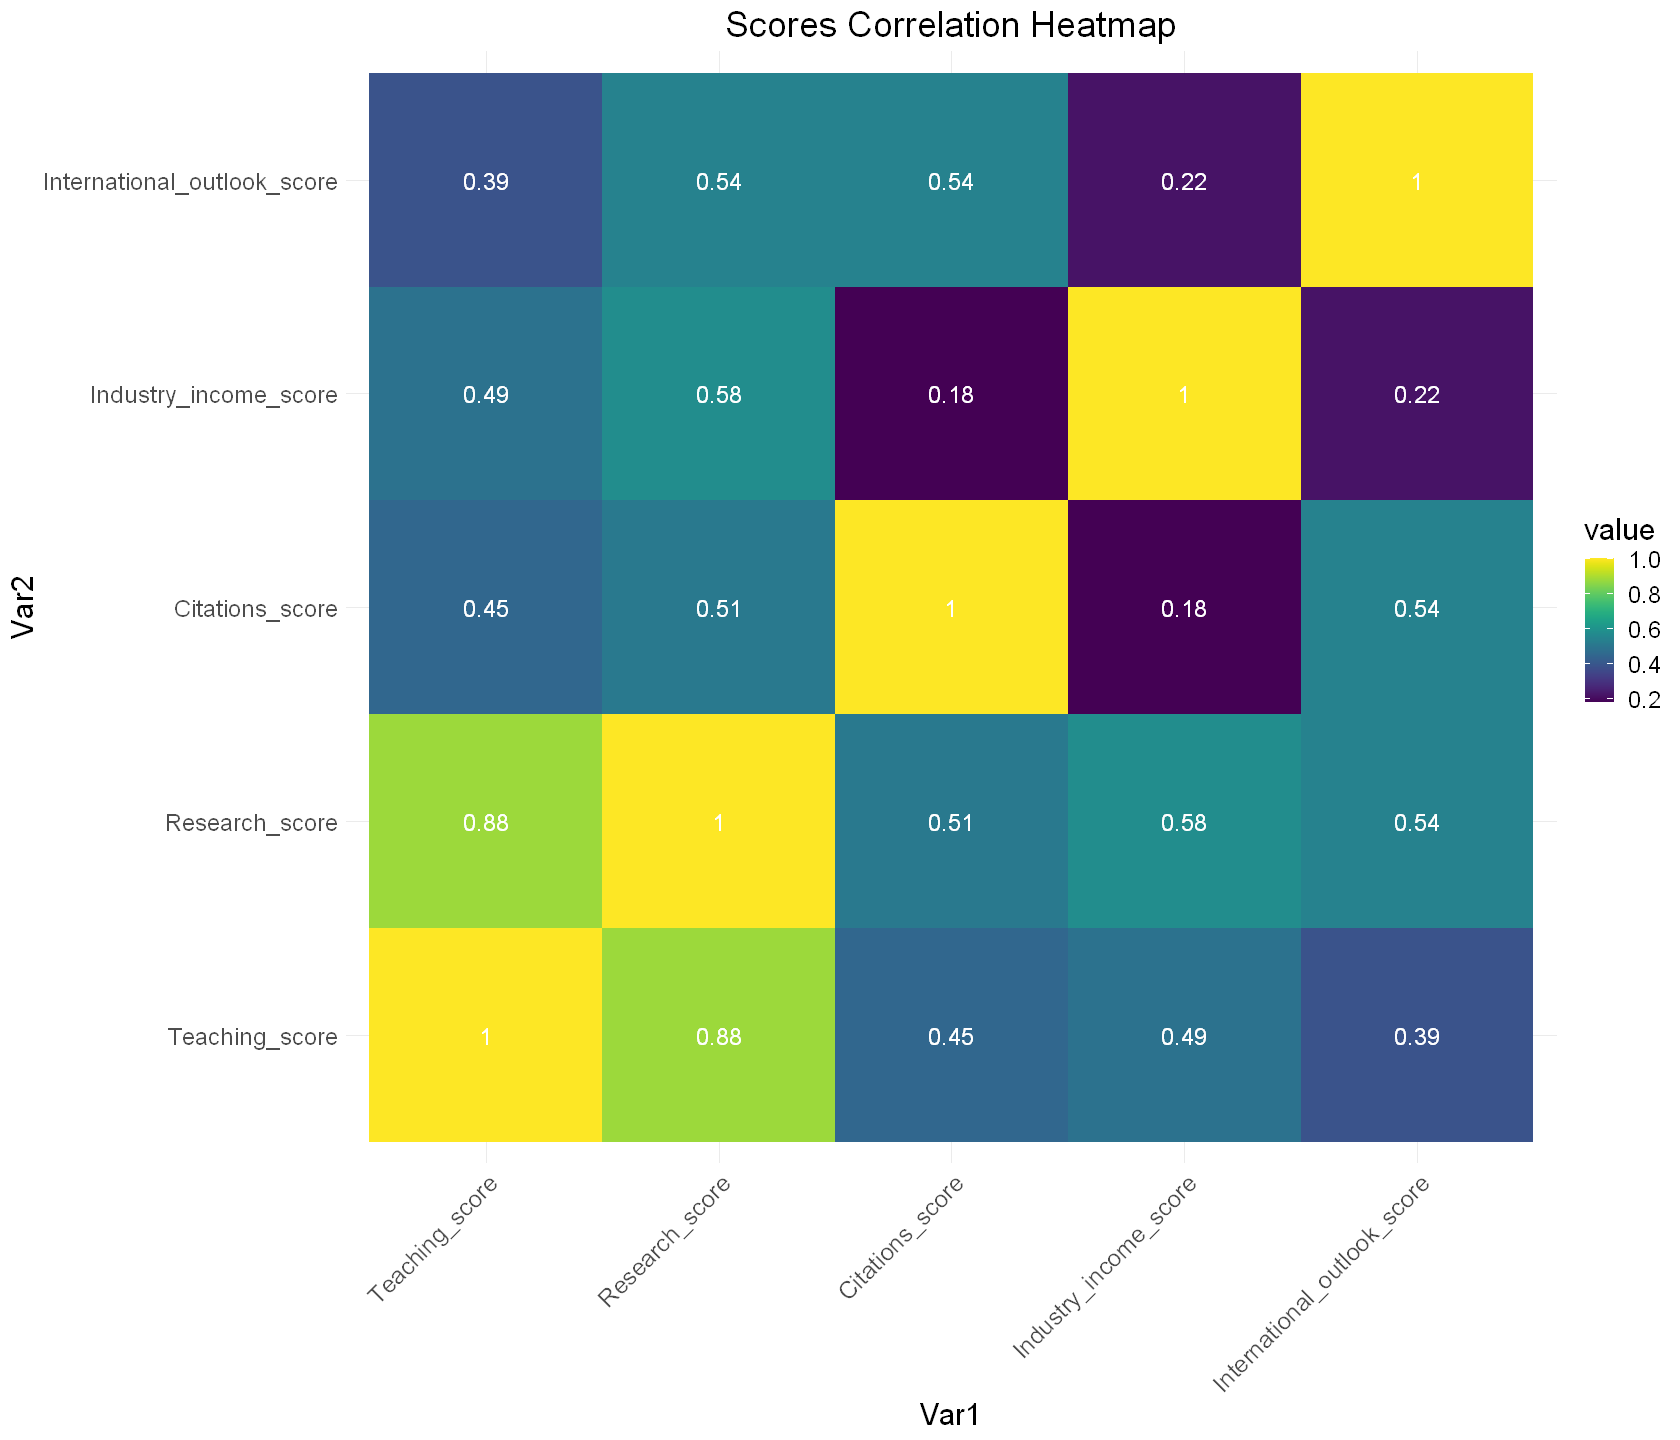

In [62]:
options(repr.plot.width = 14, repr.plot.height =12)
df_scores = df %>% select(Teaching_score, Research_score, Citations_score, Industry_income_score, International_outlook_score)
corr<- round(cor(df_scores),2)
melted_corr<- melt(corr)
ggplot(data = melted_corr, aes(x=Var1, y=Var2,
                                   fill=value)) + geom_tile() +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  
  labs(title = "Scores Correlation Heatmap") + geom_text(aes(Var2, Var1, label = value), 
          color = "white", size = 5) + scale_fill_viridis() +
  theme(plot.title = element_text(hjust = 0.5),text = element_text(size=18))

A common belief is that countries with a high number of universities might result in a high international outlook score. A bar graph of 20 countries with the largest number of universities will provide insights into predicting the international outlook score. The US has the most universities (171) among all the countries, and the US is indeed a great destination for students who want to study abroad. However, we will have to look further into the top 20 countries with the highest international outlook score to see if they correspond to those with the largest number of universities.

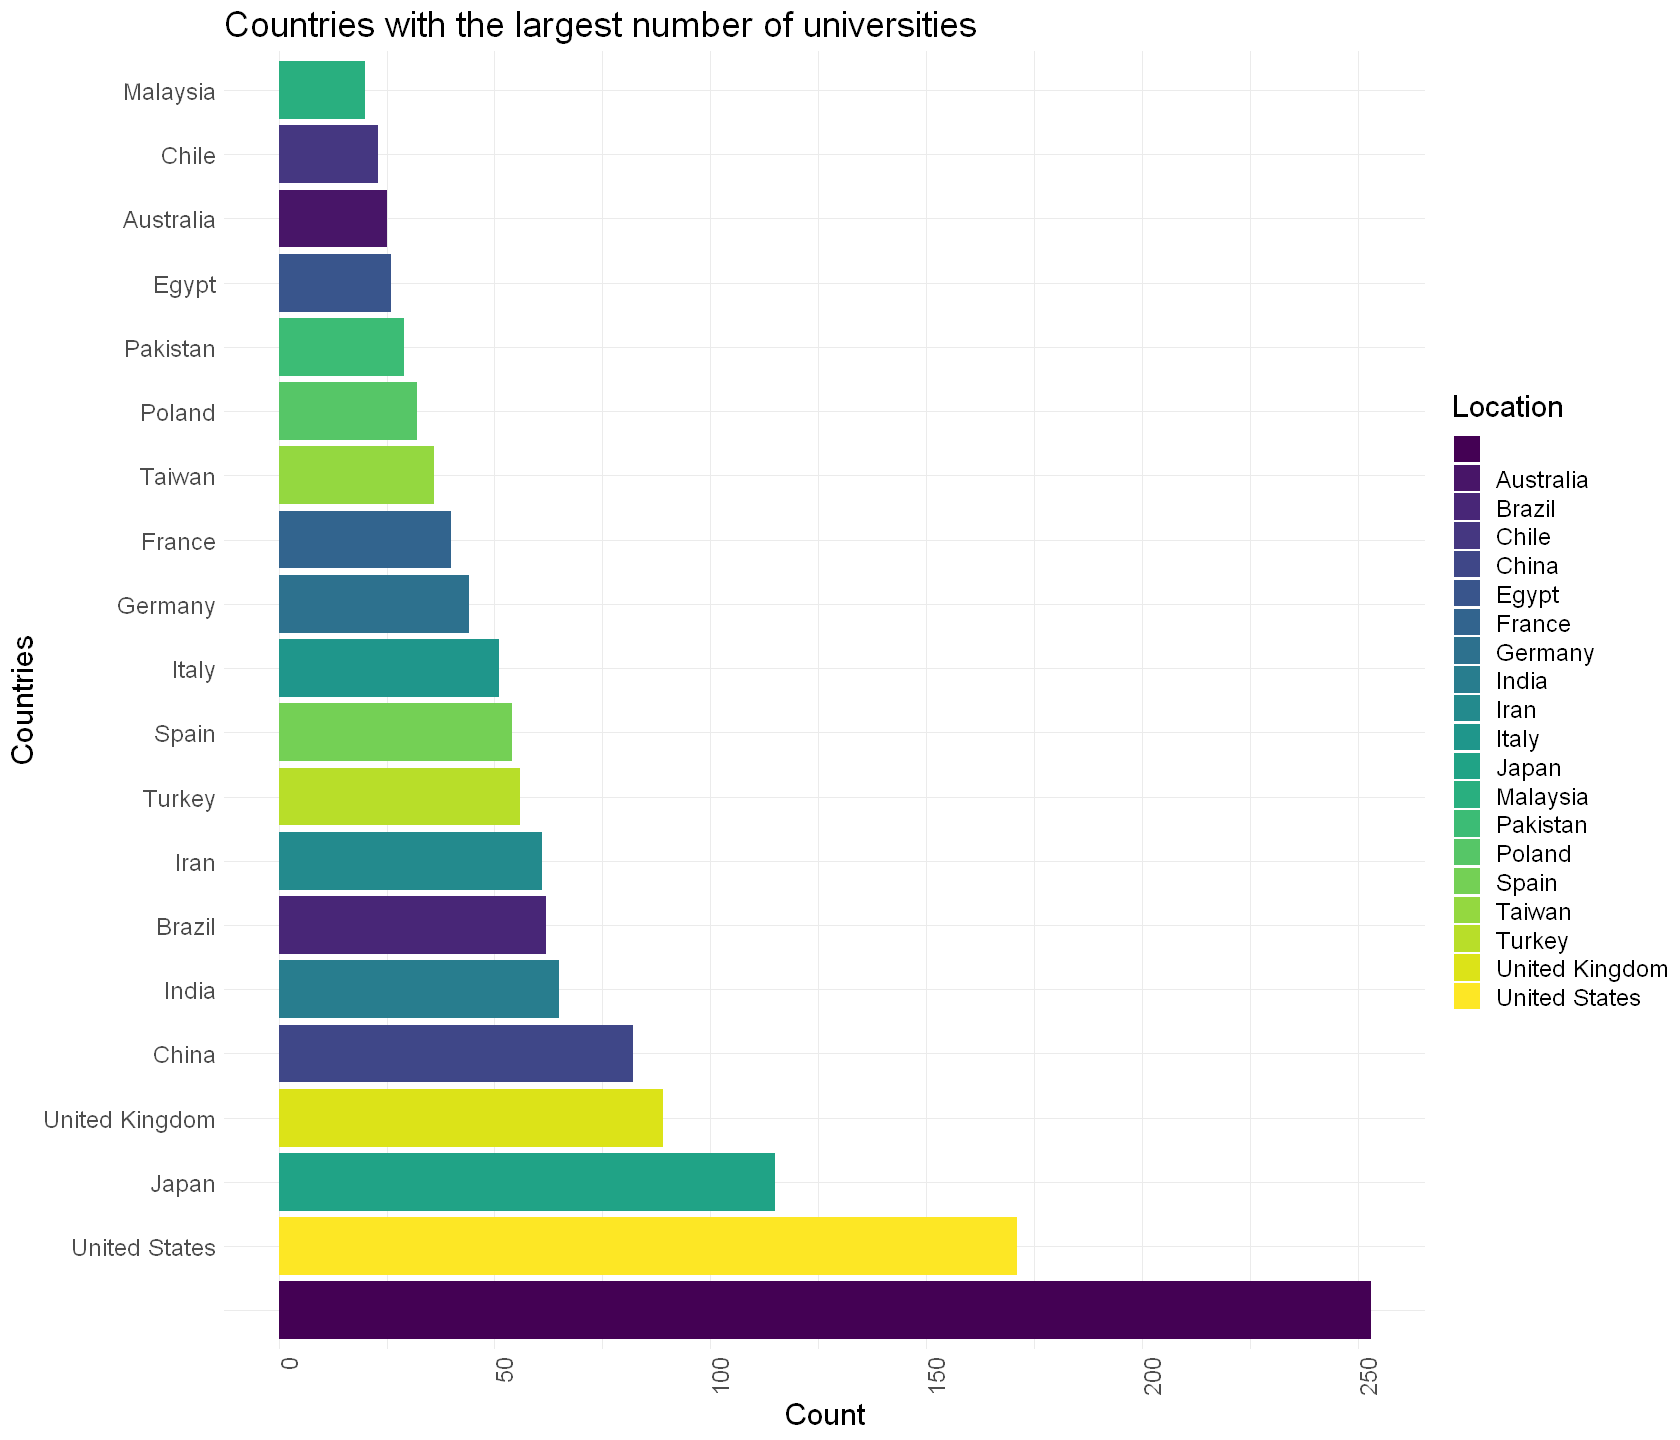

In [63]:
options(repr.plot.width = 14, repr.plot.height =12)
top_20_locations <- head(sort(table(df$location), decreasing = TRUE), 20)
top_20_countries_df <- data.frame(Location = names(top_20_locations), Count = as.numeric(top_20_locations))

ggplot(top_20_countries_df, aes(x = reorder(Location, -Count), y = Count, fill = Location)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Countries with the largest number of universities",
       x = "Countries",
       y = "Count") +
  coord_flip() + scale_fill_viridis(discrete = TRUE) + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1),text = element_text(size=18))

It seems like countries with the highest number of universities do not necessarily have the highest mean outlook score. Indeed, Luxembourg has a remarkably high average international outlook score, 99.4 out of 100. This is understandable since Luxembourg has only one university, so this number might not be reliable. Even though the US has the most universities in this data, the US could not make it to the top 20 highest average international outlook score.

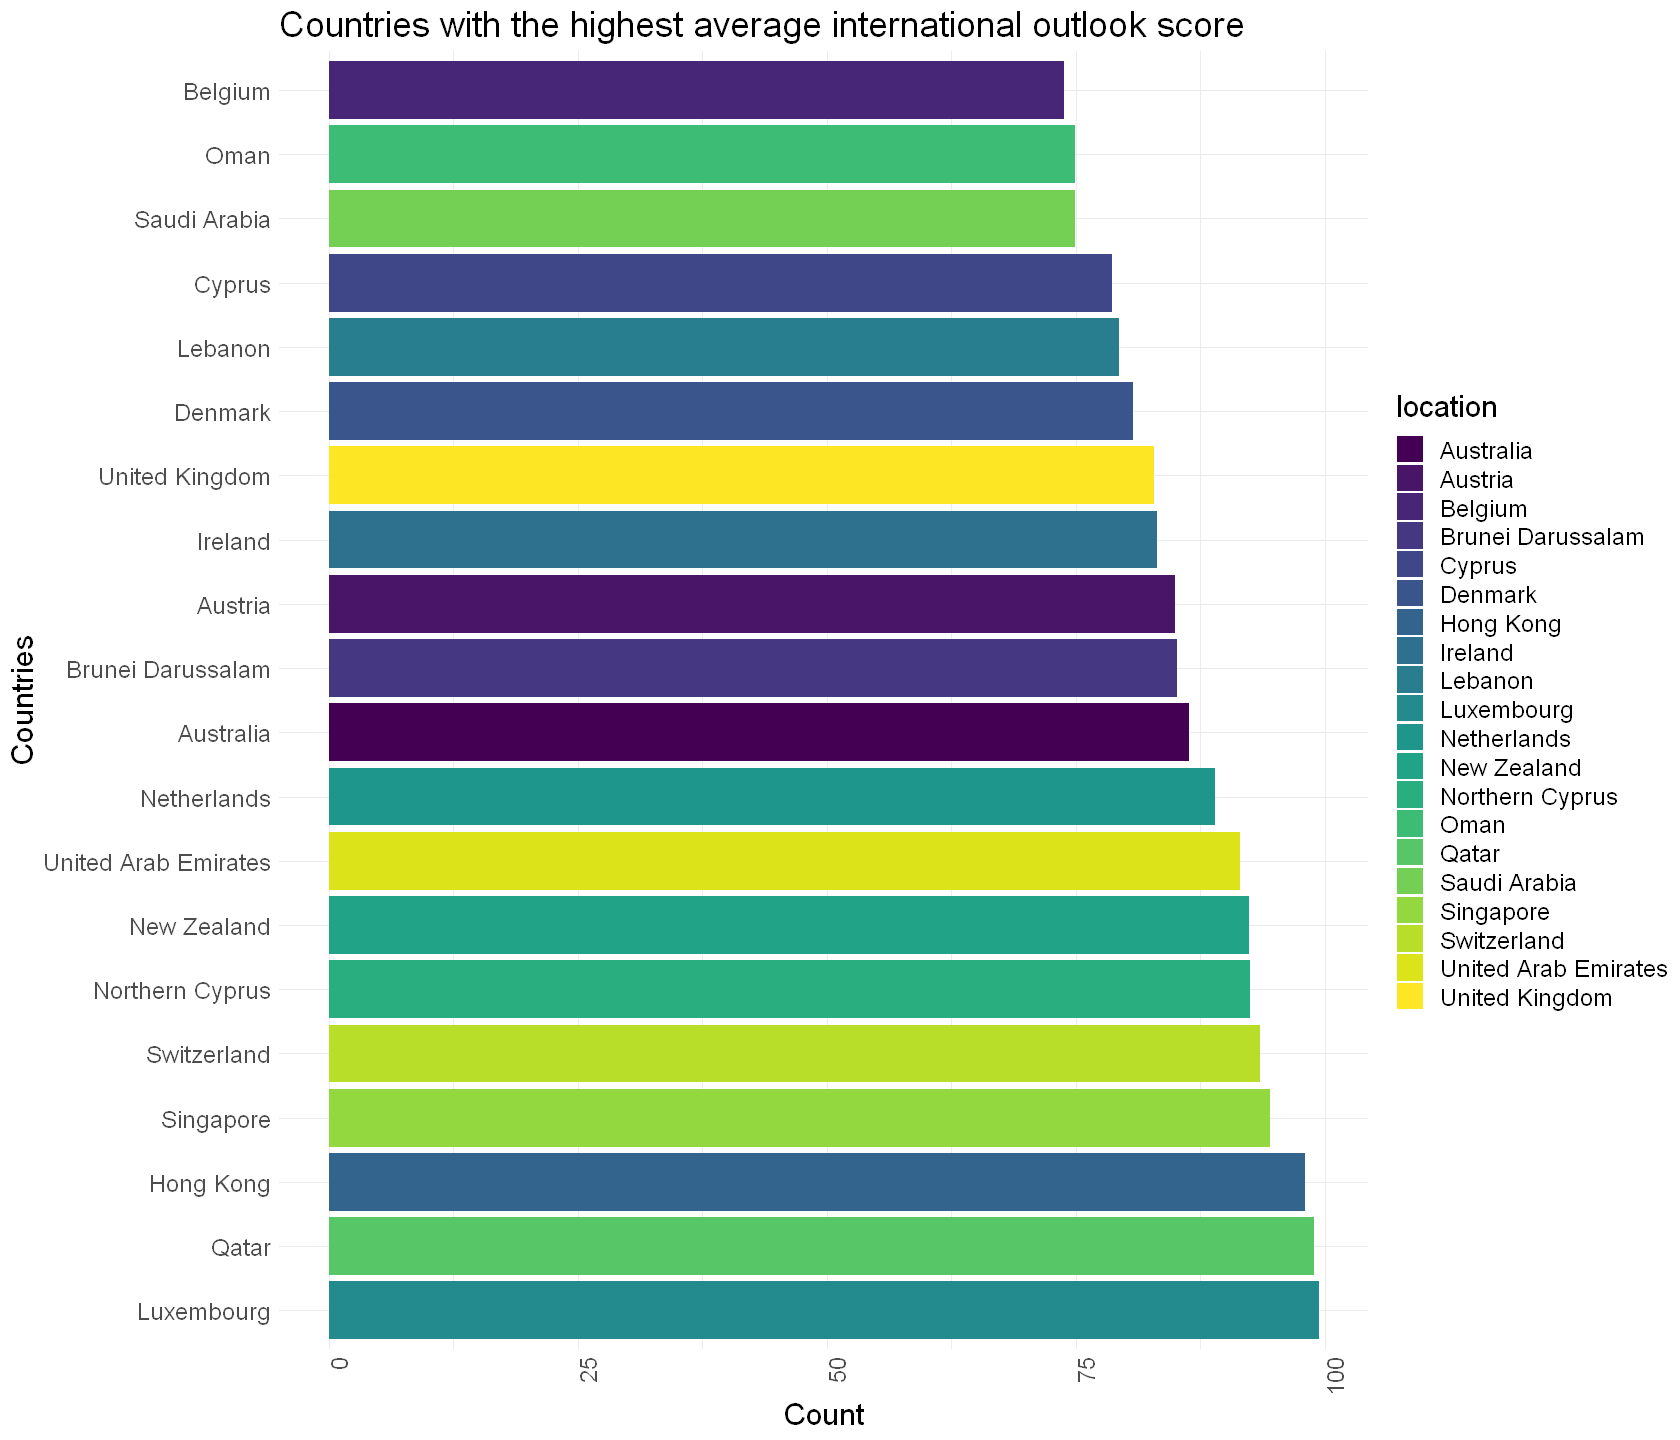

In [64]:
options(repr.plot.width = 14, repr.plot.height =12)
top_20_countries_outlook <- df %>% group_by(location) %>% summarise(mean_outlook = mean(International_outlook_score)) %>% arrange(desc(mean_outlook)) %>% head(20)
top_20_countries_outlook %>% ggplot(aes(x=fct_reorder(location, -mean_outlook),y=mean_outlook,fill = location)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Countries with the highest average international outlook score",
       x = "Countries",
       y = "Count") +
  coord_flip() + scale_fill_viridis(discrete = TRUE) + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1),text = element_text(size=18))


In [65]:
df %>% group_by(location) %>% summarise(mean_outlook = mean(International_outlook_score)) %>% filter(location=="United States")

location,mean_outlook
<chr>,<dbl>
United States,49.96199


While it is a common belief that top universities tend to have high international outlook scores, the data from the 2023 rankings demonstrates a surprising picture. The plot below describes top 20 universities in 2023 ranking, along with their respective international outlook scores. Surprisingly, more than half of the universities with highest international outlook score fall within the ranking range of 200-300. Notably, the university with the highest international outlook score is Macau University of Science and Technology, which landed in top 201-250 according to the 2023 ranking data. Besides, it is worth mentioning that Imperial College London stands out as the highest-ranked university (10) to secure a spot in the top 20 highest international outlook scores. 

Warning message:
"Removed 10 rows containing missing values (`geom_text()`)."


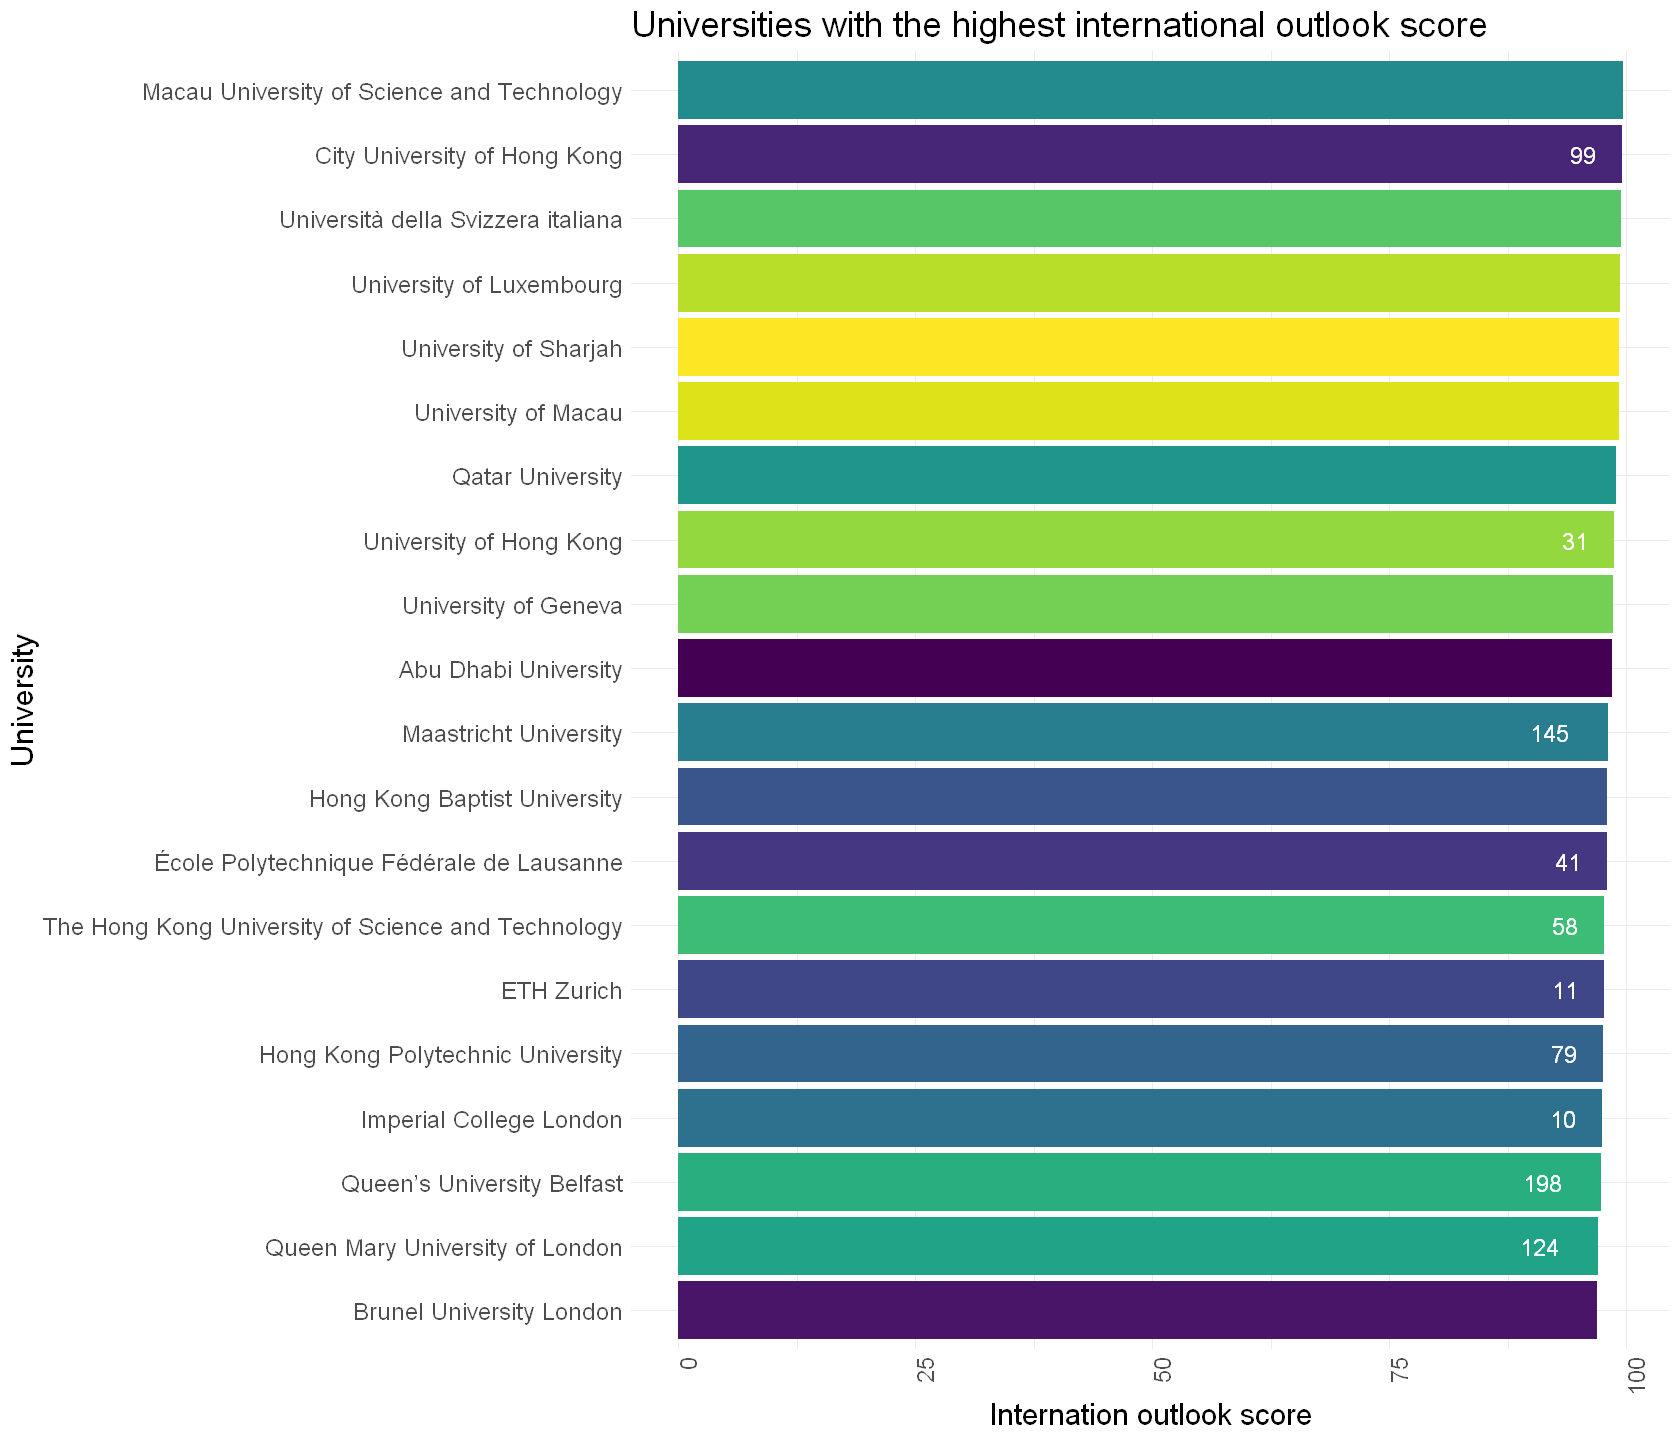

In [66]:
options(repr.plot.width = 14, repr.plot.height =12)
top_uni_outlook <- df %>% group_by(International_outlook_score) %>% arrange(desc(International_outlook_score)) %>% head(20)
top_uni_outlook %>% ggplot(aes(x=reorder(university_name, International_outlook_score),y=International_outlook_score,fill = university_name)) +
  geom_bar(stat = "identity") + guides(fill="none") + 
  theme_minimal() + 
  labs(title = "Universities with the highest international outlook score",
       x = "University",
       y = "Internation outlook score") +
  coord_flip() + scale_fill_viridis(discrete = TRUE) + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1),text = element_text(size=18)) + geom_text(aes(label = university_rank), hjust = 2, size = 5,colour = "white")


## Methods and Plan:

- Based on the EDA step, we believe that the Multiple Linear Regression(MLR) method is suitable for predicting the International Outlook score. For example, we witnessed a relatively strong linear correlation between the number of international students and the target variable. Besides, using a linear model helps facilitate the understanding of the extent to which the target variable changes in response to the variations among other factors. This is extremely significant since we focus not only on inference but also on estimating future data. Understanding how the variables behave will reduce the bias in predicting unseen data from potential errors such as multicollinearity. In order to carry out the MLR method, there are a few assumptions we make to ensure the validity of the model:
1. Normality of the error terms 
2. Equal Variance of the error terms 
3. Non-multicollinearity of the predictors
4. Independence of the observations
5. Linear relationship between predictors and target variable
- However, concerns arise regarding the aforementioned assumptions. Examining the correlations between different scores for a university in the heatmap above, we noted a high correlation between `Research_score` and `Teaching_score`, violating the assumption of non-multicollinearity. To address this, we may employ variable selection methods, such as the LASSO method. Furthermore, we can not guarantee the constant variance of the error terms, which is the case of heteroscedasticity. An effective way to identify the issue is to assess the plot of residuals versus fitted values. Considering the shortcomings of the MLR method, it may not fully capture the complex relationship between the target and explanatory variables. There is uncertainty regarding the existence of a linear relationship among variables and how they interact. Nevertheless, initiating the study with a linear regression model provides a foundation for further exploration and understanding based on the obtained results.


## Implementation of a proposed model

In [67]:
df_model <- df %>% select(-c(Overall_score,university_name,location,Male_Percentage,university_rank))


In [68]:
df_model <- df_model %>% mutate(Num_student = complete(mice(df_model,method = "pmm"))$Num_student,
                                No_of_student_per_staff = complete(mice(df_model,method = "pmm"))$No_of_student_per_staff,
                                International_student = complete(mice(df_model,method = "pmm"))$International_student,
                                Female_Percentage = complete(mice(df_model,method = "pmm"))$Female_Percentage
)


 iter imp variable
  1   1  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  1   2  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  1   3  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  1   4  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  1   5  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  2   1  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  2   2  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  2   3  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  2   4  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  2   5  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  3   1  Num_student  No_of_student_per_staff  International_student  Female_Percentage
  3   2  Num

In [69]:
set.seed(301)
split <- initial_split(df_model,0.5)
df_lasso <- training(split)
df_fit <- testing(split)


In [70]:
set.seed(301)
lasso_cv <- cv.glmnet(as.matrix(df_lasso[-8]),as.matrix(df_lasso$International_outlook_score), alpha = 1, nfolds=10)
beta_lasso <- coef(lasso_cv,s="lambda.min")
beta_lasso

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              2.022512e+01
Num_student              1.741195e-05
No_of_student_per_staff -1.709570e-03
International_student    1.223158e+02
Teaching_score          -4.899578e-01
Research_score           4.714725e-01
Citations_score          1.826829e-01
Industry_income_score   -4.569639e-02
Female_Percentage        1.879587e+01

In [71]:
mlr_model <- lm(International_outlook_score~.,data=df_fit)

In [72]:
tidy(prediction_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),22.074,2.444,9.033,0.000
Num_student,0.000,0.000,0.275,0.783
No_of_student_per_staff,-0.062,0.042,-1.478,0.140
International_student,123.348,3.783,32.603,0.000
Teaching_score,-0.605,0.063,-9.599,0.000
Research_score,0.569,0.057,9.948,0.000
Citations_score,0.148,0.016,9.443,0.000
Industry_income_score,0.005,0.032,0.149,0.882
Female_Percentage,16.392,3.047,5.380,0.000


After considering the LASSO shrinkage method for variable selection, we decided to keep all the covariates in the final model. Based on the table above, only the intercept, `Num_student`, `No_of_student_per_staff`, and `Industry_income_score` are statistically insignificant at a 5% significance level. Furthermore, the adjusted R^2 score stands at an acceptable rate, 0.7488, suggesting a good fit for the model. However, we are uncertain about the performance of the model on unseen data, so it is crucial to perform cross-validation on the training data to assess this.

## Reference:

Syed Ali Taqi. (2023). <i>World University Rankings 2023</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6394958 <br>
https://www.kaggle.com/datasets/samiatisha/world-university-rankings-2023-clean-dataset